In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

Text(0.5, 1.0, 'power_production_wind_avg')

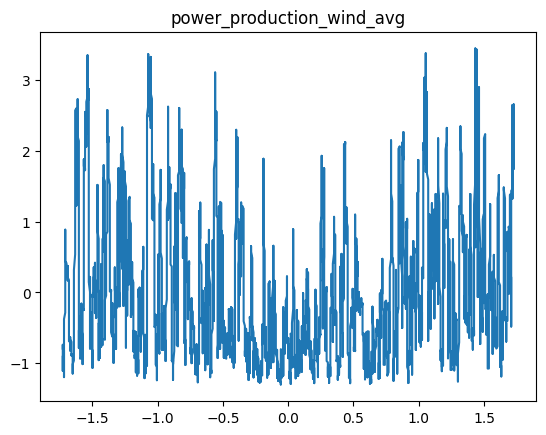

In [160]:
df = pd.read_csv("..\data\ElectricityMap_DE_2021.csv", sep=",")
df = df[["datetime","power_production_wind_avg"]]
df['datetime'] = pd.to_datetime(df['datetime'])
# seperate datetime into day of year and time of day
df["dayofyear"] = df["datetime"].dt.dayofyear
df['hour'] = [time.hour for time in df['datetime']]

df.head()

y = df[[ "dayofyear","hour","power_production_wind_avg"]]
# normalize data
y = (y-y.mean())/y.std()

t = np.arange(0, len(y)+1, 1)
#y = np.sin(0.03*t)

plt.plot(y["dayofyear"],y["power_production_wind_avg"])
#plt.plot(y)
plt.title("power_production_wind_avg")


In [161]:
# df.dtypes
# # change column type to DateTime
# # df['datetime'] = pd.to_datetime(df['datetime'])
# date_cols = df.columns[0:4]
# df[date_cols] = df[date_cols].apply(pd.to_datetime)
# df.dtypes
# df.head()

In [162]:
for i in range(df.shape[1]):
    print(f"{df.columns.values[i]}: {df.dtypes[i]}")

datetime: datetime64[ns, UTC]
power_production_wind_avg: float64
dayofyear: int64
hour: int64


In [163]:
print(df.shape)

(8760, 4)


In [164]:
# from wetterdienst.provider.dwd.observation import DwdObservationRequest, DwdObservationDataset, DwdObservationPeriod, DwdObservationResolution
# from wetterdienst import Wetterdienst, Resolution, Period

# API = Wetterdienst(provider="dwd", network="observation")

# stations = DwdObservationRequest(
#     parameter=DwdObservationDataset.CLOUDINESS,
#     resolution=Resolution.DAILY,
#     start_date="2021-01-01",
#     end_date="2021-01-05"
# )
# print(next(stations.all().values.query()))

# Wetterdienst.discover()

In [165]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

In [166]:
# testplit as usual, so we get untouched data for later evaluation
testsplit = int(0.8 * y.shape[0])
print(testsplit)

# how many "x" inputs to provide in the RNN
past_history = 24*25

# how many "yhat" outputs to make/how many timesteps into the future to predict
future_target = 24

# this can be set to 1. If you have extremely large datasets where values 
# don't change a lot during single time steps, this can be set to a higher
# value such that, e.g., only every 6th time step is used 
step = 1

# prepare the data
# inputs here are y and y, since we're only going to predict a single feature (power production wind) at first 
# "single_step" needs to be set to "True" if only the next timestep should be predicted
x_train_single, y_train_single = multivariate_data(y["power_production_wind_avg"].to_numpy(), y["power_production_wind_avg"], 0, testsplit, 
                                                   past_history, future_target, step,
                                                   single_step=False)
x_test_single, y_test_single   = multivariate_data(y["power_production_wind_avg"].to_numpy(), y["power_production_wind_avg"], testsplit, None, 
                                                   past_history, future_target, step,
                                                   single_step=False)
# x_train_single, y_train_single = multivariate_data(y, y, 0, testsplit, 
#                                                    past_history, future_target, step,
#                                                    single_step=False)
# x_test_single, y_test_single   = multivariate_data(y, y, testsplit, None, 
#                                                    past_history, future_target, step,
#                                                    single_step=False)                                                   

# the network later expects arrays with 3 dimensions, so we have to reshape
# the x_... arrays to reflect that they contain a single feature
x_train_single = x_train_single.reshape(*x_train_single.shape, 1)
x_test_single  = x_test_single.reshape( *x_test_single.shape, 1)

# print shapes
print("shape of y:", y.shape)
print("shapes of x_train and y_train: ", x_train_single.shape, y_train_single.shape)
print("shapes of x_test and y_test: ", x_test_single.shape, y_test_single.shape)

# print a few values
print("")
print(x_train_single[:3,:3])

print()
print("x_train[300]: ", *x_train_single[300][:3], "...")
print("y_train[0] :  ", y_train_single[0][:3], "...")

7008
shape of y: (8760, 3)
shapes of x_train and y_train:  (6648, 360, 1) (6648, 24)
shapes of x_test and y_test:  (1368, 360, 1) (1368, 24)

[[[-0.90927396]
  [-0.95318233]
  [-0.99663437]]

 [[-0.95318233]
  [-0.99663437]
  [-1.02875441]]

 [[-0.99663437]
  [-1.02875441]
  [-1.05103816]]]

x_train[300]:  [2.64958538] [2.72832637] [2.69980621] ...
y_train[0] :   [-0.91961727 -0.92656351 -0.92691843] ...


In [167]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras import backend as K
from tensorflow.keras.backend import clear_session
# clear_session() deletes stale model, so that when this cell is executed again,
# no older model reside in memory
clear_session()

# r2_score defined manually, since it's not implemented in keras
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# below, create a sequential model like before called "single_feature_model"
# 
# then, add an LSTM layer (the class is already imported) with 128 hidden
# vector components. As a second argument you have to provide the
# "input_shape=", that has to be a tuple of the second and third dimension
# of x_train_single, like (20, 30). You can use x_train_single.shape for example to get them
# 
# lastly, add a "Dense" layer like in the lessons before, with as many neurons as
# there are future predictions. That number is saved in the variable "future_target".
# choose an appropriate activation function here. Which ones make sense?
# YOUR CODE HERE
single_feature_model = Sequential()
single_feature_model.add(LSTM(128, input_shape=x_train_single.shape[1:3]))
single_feature_model.add(Dense(future_target, activation='selu'))

# raise NotImplementedError()

# compile the model with the optimizer 'adam', an appropriate loss function, and 
# the "r2_score" defined above as a metric
# YOUR CODE HERE
single_feature_model.compile(optimizer="adam", loss="mse", metrics=r2_score)
#raise NotImplementedError()

# check what the model looks like
single_feature_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 24)                3096      
                                                                 
Total params: 69,656
Trainable params: 69,656
Non-trainable params: 0
_________________________________________________________________


In [168]:
single_feature_history = single_feature_model.fit(x_train_single, y_train_single, epochs=2, validation_split=0.25)

Epoch 1/2
156/156 [==============================] - 36s 227ms/step - loss: 0.4656 - r2_score: 0.4975 - val_loss: 0.3706 - val_r2_score: -1.4805
Epoch 2/2
156/156 [==============================] - 30s 190ms/step - loss: 0.3921 - r2_score: 0.5771 - val_loss: 0.3548 - val_r2_score: -1.2727


dict_keys(['loss', 'r2_score', 'val_loss', 'val_r2_score'])


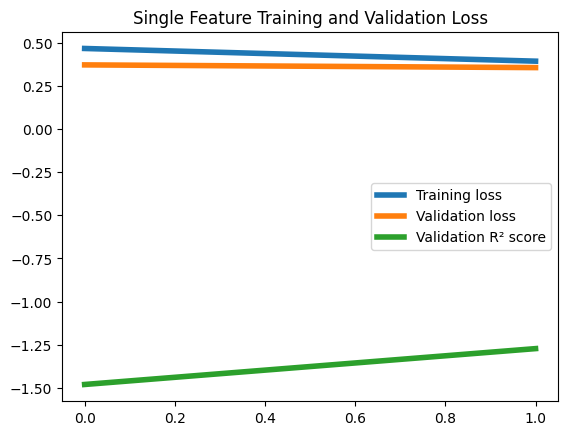

In [169]:
print(single_feature_history.history.keys())

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    val_r2_score = history.history['val_r2_score']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, lw=4, label='Training loss')
    plt.plot(epochs, val_loss, lw=4, label='Validation loss')
    plt.plot(epochs, val_r2_score, lw=4, label='Validation R² score')
    plt.title(title)
    plt.legend()

    plt.show()
    
plot_train_history(single_feature_history, 'Single Feature Training and Validation Loss')

In [170]:
y_hat = single_feature_model.predict(x_test_single)

43/43 [==============================] - 3s 68ms/step


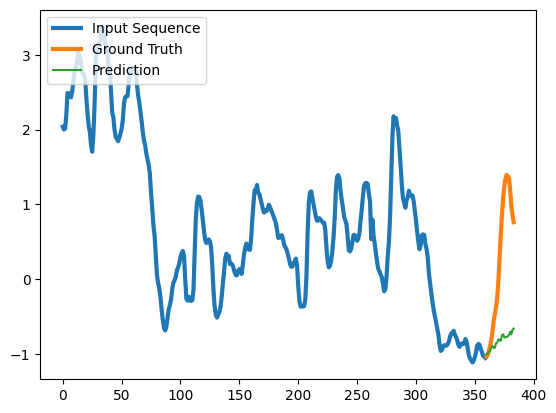

In [171]:
plt.figure()

plt.plot(t[:past_history], x_test_single[0,:], lw=3, label="Input Sequence")
plt.plot(t[past_history:past_history+future_target], y_test_single[0], lw=3, label="Ground Truth")
plt.plot(t[past_history:past_history+future_target], y_hat[0], label="Prediction")
plt.legend(loc='upper left')

plt.show()